# Desempenho ENEM

> Modelagem de Desempenho no Enem: identificação das escolas que mais agregam resultados aos seus alunos

Tradicionalmente consideram-se melhores escolas aquelas com melhores resultados médios de seus alunos.
No entanto, muito do resultado de um aluno está fortemente relacionado às suas características sócio-econômicas, que também estão associadas à escola que cursa.
Deseja-se um método objetivo para distinguir escolas com alunos com desempenhos abaixo ou acima do que se espera deles, em função dessas características socioeconômicas, que possa ser imputado como contribuição da escola.

Por exemplo, se considerarmos apenas o fator `renda dos pais`, poderia-se agregar as escolas em patamares dessa renda e assim, para cada segmento, identificar as escolas com melhores resultados o que limitaria a influência do fator renda dentro de cada segmento.
Idealmente, procuraríamos generalizar esse isolamento de fatores, treinando um modelo preditivo para que estime `o desempenho de um aluno em função de todas as suas características, excluindo apenas a escola frequentada`.
Depois compararíamos esse desempenho estimado com o desempenho real e ordenaríamos as escolas pela contribuição ao desempenho além do esperado.

Os microdados anonimizados do Enem encontram-se publicados pelo `Inep (http://inep.gov.br/web/guest/microdados)` com boa qualidade de dados em múltiplos anos, para milhões de alunos.
Os dados socioeconômicos e de desempenho na prova encontram-se presentes para cada aluno individualmente, viabilizando assim a modelagem desejada.

> Exemplo de análise dos dados do ENEM para identificação de melhores escolas, considerando diversas características: https://exame.com/brasil/7-rankings-mais-realistas-do-desempenho-das-escolas-no-enem/

> - Micro-dados ENEM 2019: http://download.inep.gov.br/microdados/microdados_enem_2019.zip
> - 650MB compactados, 3GB final

---


# Analise inicial

A seguinte análise serve para conhecer melhor os dados disponíveis, apresentar alguma técnicas básicas de análise utilizando pandas e responder a algumas perguntas sobre os dados:

- número total de alunos do Enem 2019:

- relação entre desempenho e

  - renda dos pais
  - gênero
  - raça
  - tipo de escola, pública ou privada
  - estado de origem
  - etc

- reproduzir a análise e os resultados do excelente exemplo de jornalismo de dados realizado pelo jornal Estadão:
  http://infograficos.estadao.com.br/educacao/enem/desigualdades-de-genero-e-raca/

Dicionário de dados disponível junto com os dados baixados: recomenda-se a leitura para entendimento do significado das colunas

Aproveitei código de [Gustavo Bonesso](https://www.kaggle.com/gbonesso) para a análise inicial de 2016.

Recomendo começar as análises com um recorte que reduza o número de observações, seja diretamente limitando o número de linhas que serão lidas ou indiretamente selecionando um único estado ou município. O importante é que consiga validar rapidamente suas hipóteses antes de rodar o treinamento com todos os dados disponíveis.

O dataset Enem 2019 contém 5.095.270 de linhas! Então vejam com cuidado qual o tamanho do seu recorte que lhe permite trabalhar com velocidade.

Para facilitar o acesso ao dicionário de dados, fiz um upload separado nos arquivos da turma: https://drive.google.com/file/d/1hUB_2ySBsOfvIQxHxL4cyE7WY_739BhB/view?usp=sharing


# Engenharia de dados


In [85]:
# import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collector, para recuperar memória após carregar o dataset inicial

# %matplotlib inline

# Input data files are available in the "./microdados_enem_2019/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os

In [86]:
# Publiquei o dataset com os dados do Enem 2019 unicamente para o DF, extraído do site do Inep
# DropBox: https://dl.dropboxusercontent.com/s/30z9cido6jykxpf/df_enem2019.csv
# !wget https://dl.dropboxusercontent.com/s/30z9cido6jykxpf/df_enem2019.csv

print(os.listdir("."))
path = './dados/df_enem2019.csv'

['best_model.pkl', 'dados', 'ENEM_2019_socio_economico_v2.ipynb', 'Enem_dtreeviz', 'Enem_dtreeviz.svg', 'Ensemble_ENEM_2019_socio_economico_v3.ipynb', 'Ensemble_RF_ENEM_2019_socio_economico_v2.ipynb', 'Ensemble_RF_ENEM_2019_socio_economico_v3.ipynb', 'Ensemble_RF_ENEM_2019_socio_economico_v4.ipynb', 'exemplo-dtreewiz.ipynb', 'exercício_nlp_americanas_respondido.ipynb', 'inspection-permutarion-importance.ipynb', 'Pipeline_mixto_v2.ipynb']


In [87]:
# fonte: ./microdados_enem_2019/DADOS/MICRODADOS_ENEM_2019.csv
# Considerando o tamanho do dataset é prudente descobrir sua estrutura aos poucos,
# sem procurar carregar tudo de uma só vez
# Lê só as 5 primeiras linhas
df = pd.read_csv(
    path,
    nrows=5000,  # só as 5k primeiras linhas
    # encoding='utf-8',
    sep=",",
)
df

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001009418,2019,5300108,Brasília,53,DF,20,M,1,1,...,B,A,A,C,A,A,C,A,B,B
1,190001041173,2019,5300108,Brasília,53,DF,17,F,1,3,...,B,A,A,B,A,A,C,B,A,B
2,190001123448,2019,5300108,Brasília,53,DF,22,F,1,3,...,A,A,A,B,A,A,D,B,A,B
3,190001128418,2019,5300108,Brasília,53,DF,21,F,1,3,...,A,A,A,B,B,B,C,A,A,B
4,190001132590,2019,5300108,Brasília,53,DF,19,F,1,3,...,B,A,A,C,B,A,C,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,190002034880,2019,5300108,Brasília,53,DF,21,M,1,2,...,B,A,A,B,A,A,D,A,B,B
4996,190002034881,2019,5300108,Brasília,53,DF,18,F,1,1,...,B,A,B,C,B,B,D,B,C,B
4997,190002034882,2019,5300108,Brasília,53,DF,18,F,1,3,...,B,A,A,B,A,A,D,B,B,B
4998,190002034883,2019,5300108,Brasília,53,DF,21,F,1,2,...,B,A,B,B,A,A,D,B,B,B


In [88]:
# 136 colunas!
# Mostra o nome das colunas
print(list(df.columns))
len(df.columns)

['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_

136

In [89]:
# Caso queira referenciar um conjunto de colunas por posição e não apenas por nome
list(zip(range(len(df.columns)), df.columns))

[(0, 'NU_INSCRICAO'),
 (1, 'NU_ANO'),
 (2, 'CO_MUNICIPIO_RESIDENCIA'),
 (3, 'NO_MUNICIPIO_RESIDENCIA'),
 (4, 'CO_UF_RESIDENCIA'),
 (5, 'SG_UF_RESIDENCIA'),
 (6, 'NU_IDADE'),
 (7, 'TP_SEXO'),
 (8, 'TP_ESTADO_CIVIL'),
 (9, 'TP_COR_RACA'),
 (10, 'TP_NACIONALIDADE'),
 (11, 'CO_MUNICIPIO_NASCIMENTO'),
 (12, 'NO_MUNICIPIO_NASCIMENTO'),
 (13, 'CO_UF_NASCIMENTO'),
 (14, 'SG_UF_NASCIMENTO'),
 (15, 'TP_ST_CONCLUSAO'),
 (16, 'TP_ANO_CONCLUIU'),
 (17, 'TP_ESCOLA'),
 (18, 'TP_ENSINO'),
 (19, 'IN_TREINEIRO'),
 (20, 'CO_ESCOLA'),
 (21, 'CO_MUNICIPIO_ESC'),
 (22, 'NO_MUNICIPIO_ESC'),
 (23, 'CO_UF_ESC'),
 (24, 'SG_UF_ESC'),
 (25, 'TP_DEPENDENCIA_ADM_ESC'),
 (26, 'TP_LOCALIZACAO_ESC'),
 (27, 'TP_SIT_FUNC_ESC'),
 (28, 'IN_BAIXA_VISAO'),
 (29, 'IN_CEGUEIRA'),
 (30, 'IN_SURDEZ'),
 (31, 'IN_DEFICIENCIA_AUDITIVA'),
 (32, 'IN_SURDO_CEGUEIRA'),
 (33, 'IN_DEFICIENCIA_FISICA'),
 (34, 'IN_DEFICIENCIA_MENTAL'),
 (35, 'IN_DEFICIT_ATENCAO'),
 (36, 'IN_DISLEXIA'),
 (37, 'IN_DISCALCULIA'),
 (38, 'IN_AUTISMO'),
 (39, '

A semântica das variáveis representadas nas colunas do dataset está descrita no dicionário de dados.

Assim, podemos importar seletivamente apenas as colunas que sejam necessárias para a análise.

Exemplo:


In [90]:
# Seleciona as colunas de interesse
# As colunas do questionário socioeconômico são de nome Q001 a Q025
colunas = [
    "Q001",
    "Q002",
    "Q003",
    "Q004",
    "Q005",
    "Q006",
    "Q007",
    "Q008",
    "Q009",
    "Q010",
    "Q011",
    "Q012",
    "Q013",
    "Q014",
    "Q015",
    "Q016",
    "Q017",
    "Q018",
    "Q019",
    "Q020",
    "Q021",
    "Q022",
    "Q023",
    "Q024",
    "Q025",
]

In [91]:
# Forma alternativa de selecionar as mesmas colunas
df.columns[-25:]

Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [92]:
# recorte para o questionário socioeconomico (se)
se = df[colunas]
se.head()

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,D,E,C,D,2,G,B,C,D,B,...,B,A,A,C,A,A,C,A,B,B
1,G,G,D,D,2,I,A,B,C,A,...,B,A,A,B,A,A,C,B,A,B
2,F,E,D,B,4,C,A,B,C,A,...,A,A,A,B,A,A,D,B,A,B
3,E,E,A,C,3,B,A,B,C,A,...,A,A,A,B,B,B,C,A,A,B
4,E,C,F,F,4,D,C,C,C,B,...,B,A,A,C,B,A,C,B,B,B


In [93]:
# Separa as variáveis independentes (features) ou X da variável dependente (target) ou y
X = se.drop(["Q006"], axis=1)
y = se["Q006"]

In [94]:
X.sample(10)

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
505,F,F,D,D,3,A,E,E,B,A,...,B,B,A,B,A,B,D,B,B,B
3781,C,D,C,B,5,A,B,D,B,A,...,A,A,B,B,B,A,E,A,A,B
4789,B,E,B,B,4,A,B,C,C,A,...,B,A,A,B,A,A,C,A,A,B
2537,C,C,F,C,4,A,B,B,A,A,...,A,A,A,B,A,A,C,A,B,B
2019,B,C,D,F,3,A,E,E,D,A,...,C,A,B,D,B,B,D,B,C,B
2298,C,D,A,B,4,A,B,D,A,A,...,A,A,A,B,B,A,D,A,B,B
485,E,E,B,B,4,A,C,D,B,A,...,B,A,A,B,A,A,D,A,B,B
794,D,D,C,D,5,A,B,D,A,A,...,B,A,A,C,A,B,E,A,A,B
2414,C,E,B,C,6,A,B,B,A,A,...,A,A,A,B,A,A,B,A,A,A
1406,F,E,E,E,3,A,B,C,D,A,...,B,A,B,B,B,A,B,B,C,B


In [95]:
y.sample(10)

3013    Q
1635    C
808     B
789     F
1282    I
2387    C
2858    H
2168    D
235     G
2007    C
Name: Q006, dtype: object

## Dicionário de dados e utilização de **Encoder**


Para facilitar o acesso ao dicionário de dados, fiz um upload separado nos arquivos da turma: https://drive.google.com/file/d/1hUB_2ySBsOfvIQxHxL4cyE7WY_739BhB/view?usp=sharing

Olhem o dicionário de dados acima, associado ao dataset Enem 2019 DF.

Considerando que os patamares de intensidade das variáveis independentes estão
associados a letras em ordem alfabética crescente, podemos utilizar um `encoder ordinal`!
Mas, lembre-se de também testar um `OneHotEncoder` para garantir.


In [96]:
from sklearn.preprocessing import OrdinalEncoder

In [97]:
enc = OrdinalEncoder().fit(X)

In [98]:
enc.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 20],
       dtype=int64),
 array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'E'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B', 'C', 'E'], dtype=object),
 array(['A', 'B'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['A', 'B'], dtype=object),
 array(['A', 'B'], dtype=object),
 array([

In [99]:
enc.transform(X)

array([[3., 4., 2., ..., 0., 1., 1.],
       [6., 6., 3., ..., 1., 0., 1.],
       [5., 4., 3., ..., 1., 0., 1.],
       ...,
       [4., 4., 3., ..., 1., 1., 1.],
       [2., 0., 2., ..., 1., 1., 1.],
       [7., 7., 1., ..., 0., 0., 1.]])

In [100]:
X.head()

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,D,E,C,D,2,B,C,D,B,A,...,B,A,A,C,A,A,C,A,B,B
1,G,G,D,D,2,A,B,C,A,A,...,B,A,A,B,A,A,C,B,A,B
2,F,E,D,B,4,A,B,C,A,A,...,A,A,A,B,A,A,D,B,A,B
3,E,E,A,C,3,A,B,C,A,A,...,A,A,A,B,B,B,C,A,A,B
4,E,C,F,F,4,C,C,C,B,A,...,B,A,A,C,B,A,C,B,B,B


In [101]:
enc

OrdinalEncoder()

# Treinamentos com diversos modelos


## Primeiros Modelos com: _DecisionTree_ e _LogisticRegression_ com _ConfusionMatrix_


In [102]:
# Agora vamos treinar nossa árvore de decisão para uma primeira tentativa
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [103]:
# Partição treino/teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [104]:
X_train.shape, y_train.shape

((4000, 24), (4000,))

In [105]:
X_test.shape, y_test.shape

((1000, 24), (1000,))

In [106]:
# Observem que houve um shuffle na ordem das linhas
X_train

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
4227,B,C,B,B,2,A,C,C,B,A,...,B,A,B,C,A,A,C,A,B,B
4676,G,G,D,D,3,A,D,D,C,A,...,B,B,B,D,B,B,D,B,C,B
800,A,D,B,B,5,A,B,C,B,A,...,A,A,A,B,B,A,C,A,A,A
3671,H,F,D,B,7,A,C,C,B,A,...,B,A,A,B,A,B,C,A,B,B
4193,H,F,D,B,6,A,B,C,B,A,...,B,A,A,C,A,A,C,A,A,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,F,F,D,D,4,A,C,D,B,A,...,B,A,B,B,A,A,E,B,D,B
466,F,F,F,A,5,A,C,D,C,A,...,A,A,A,B,A,A,E,A,B,B
3092,E,E,B,B,2,A,C,C,B,A,...,B,A,A,D,B,A,C,A,B,B
3772,G,E,E,F,5,A,B,E,C,A,...,B,B,B,D,A,B,E,A,C,B


In [107]:
y.value_counts()

Q006
C    1447
B     923
E     521
D     462
G     274
I     171
F     171
H     166
A     156
Q     129
J      96
N      93
O      85
P      84
K      82
L      74
M      66
Name: count, dtype: int64

In [108]:
# Como temos dados categóricos, precisamos codificá-los numericamente:
enc = OrdinalEncoder().fit(X_train)

In [109]:
# Modelo básico de regressão logística para pode comparar desempenho:
log_reg = LogisticRegression(max_iter=1000).fit(enc.transform(X_train), y_train)
log_reg.score(enc.transform(X_test), y_test)

0.341

In [110]:
metrics.f1_score(y_test, log_reg.predict(enc.transform(X_test)), average="weighted")

0.2811851650631893

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay

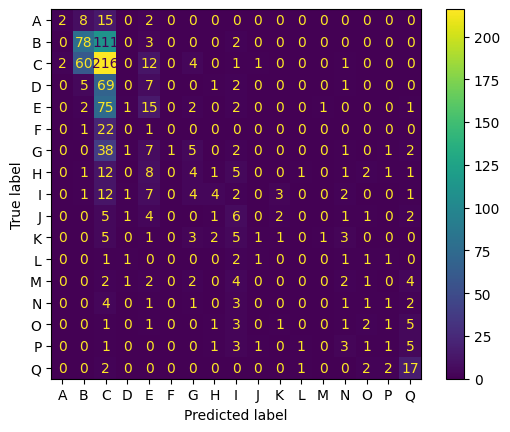

In [112]:
# Matriz de Confusão entre classes de patamares de renda familial
ConfusionMatrixDisplay.from_estimator(log_reg, enc.transform(X_test), y_test)

Não é de todo mal... 16 categorias e 31% de acurácia.

Mas dá pra ver que o modelo está chutando muito na categoria dominante (C) e errando bastante, porém com erros em categorias vizinhas.

> O F1-score bem menor deixa esse diagnóstico mais claro, apontando para o problema de desbalanceamento de classes.


In [113]:
# distribuição da amostra em patamares de renda
y.value_counts().sort_index()

Q006
A     156
B     923
C    1447
D     462
E     521
F     171
G     274
H     166
I     171
J      96
K      82
L      74
M      66
N      93
O      85
P      84
Q     129
Name: count, dtype: int64

In [114]:
import string

# 17 primeiras letras maiúsculas
ordem_renda = list(string.ascii_uppercase[:17])
print(ordem_renda)
# Q006_order=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q"]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']


<Axes: xlabel='Q006'>

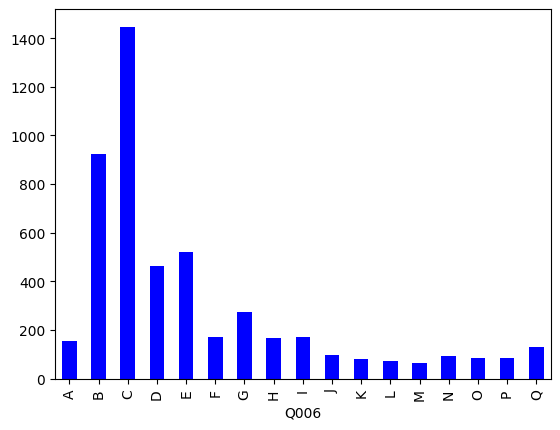

In [115]:
# distribuição do número de alunos por nível de renda
df.Q006.value_counts().sort_index().plot.bar(color="blue")

In [116]:
# ponto médio da amostra?
y.sort_values()[len(y) / 2]

'I'

In [117]:
import numpy as np

In [118]:
renda = np.where(
    y <= "C", 0, 1
)  # testa por ordem lexicográfica: A, B e C classe 0, demais letras classe 1
renda

array([1, 1, 0, ..., 1, 1, 0])

In [119]:
sum(renda) / len(renda)

0.4948

In [120]:
# Novo particionamento de dados, dessa vez apenas entre rendas baixa e alta.
# 
# Pelo dicionário de dados, o ponto de corte da renda até a classe C é para valores até ~R$ 1.500

# Partição treino/teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, renda, test_size=0.2, random_state=42
)

In [121]:
# Como temos dados categóricos, precisamos codificá-los numericamente:
enc = OrdinalEncoder().fit(X_train)

In [164]:
X_train.head()

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
4227,B,C,B,B,2,A,C,C,B,A,...,B,A,B,C,A,A,C,A,B,B
4676,G,G,D,D,3,A,D,D,C,A,...,B,B,B,D,B,B,D,B,C,B
800,A,D,B,B,5,A,B,C,B,A,...,A,A,A,B,B,A,C,A,A,A
3671,H,F,D,B,7,A,C,C,B,A,...,B,A,A,B,A,B,C,A,B,B
4193,H,F,D,B,6,A,B,C,B,A,...,B,A,A,C,A,A,C,A,A,B


In [122]:
# Modelo básico de regressão logística para pode comparar desempenho:
log_reg = LogisticRegression(max_iter=1000).fit(enc.transform(X_train), y_train)
log_reg.score(enc.transform(X_test), y_test)

0.767

In [123]:
metrics.f1_score(y_test, log_reg.predict(enc.transform(X_test)), average="weighted")

0.7665589314855262

In [124]:
from sklearn.metrics import ConfusionMatrixDisplay

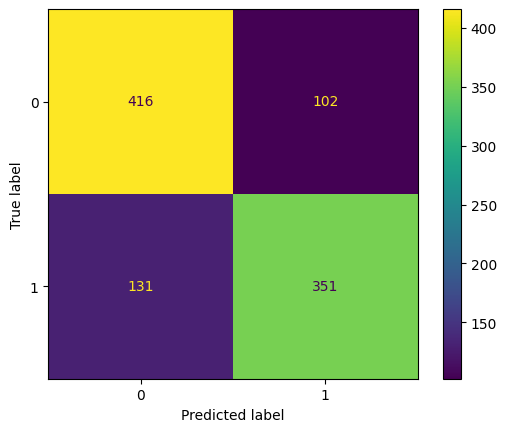

In [125]:
# Matriz de Confusão entre patamares de renda familial, acima (1) ou abaixo (0) de R$ 1.500,00 (binário) 
ConfusionMatrixDisplay.from_estimator(log_reg, enc.transform(X_test), y_test)

## Outros Modelos com: svm, DecisionTreeClassifier e etc


### Modelo svm


In [126]:
# Testando outros modelos: SVM
from sklearn import svm

svm_clf = svm.SVC(C=1.0).fit(enc.transform(X_train), y_train)

print(svm_clf.score(enc.transform(X_test), y_test))

metrics.f1_score(y_test, svm_clf.predict(enc.transform(X_test)), average="weighted")

0.765


0.763278444854521

### Modelo _TreeDecisionClassifier_ (Árvore de decisão Classificador)


In [165]:
# Testando outros modelos: Árvore de decisão Classificador
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(enc.transform(X_train), y_train)

print(tree.score(enc.transform(X_test), y_test))

metrics.f1_score(y_test, tree.predict(enc.transform(X_test)), average="weighted")

0.676


0.6760220320881283

In [167]:
# # Overfit?
# plt.figure(figsize=(20,10))
# plot_tree(tree, filled=True, fontsize=12, feature_names=X_train.columns)
# plt.show()

![Overfit Decision Tree](https://i.imgur.com/t9CktVC.png)


In [129]:
tree = DecisionTreeClassifier(max_depth=4).fit(enc.transform(X_train), y_train)
print(tree.score(enc.transform(X_test), y_test))
metrics.f1_score(y_test, tree.predict(enc.transform(X_test)), average="weighted")

0.757


0.7570726954558961

In [130]:
tree = DecisionTreeClassifier(min_samples_leaf=30).fit(enc.transform(X_train), y_train)
print(tree.score(enc.transform(X_test), y_test))
metrics.f1_score(y_test, tree.predict(enc.transform(X_test)), average="weighted")

0.759


0.7589717600470315

In [131]:
tree = DecisionTreeClassifier(min_samples_split=100, min_samples_leaf=50).fit(
    enc.transform(X_train), y_train
)
print(tree.score(enc.transform(X_test), y_test))
metrics.f1_score(y_test, tree.predict(enc.transform(X_test)), average="weighted")

0.763


0.7628182221959317

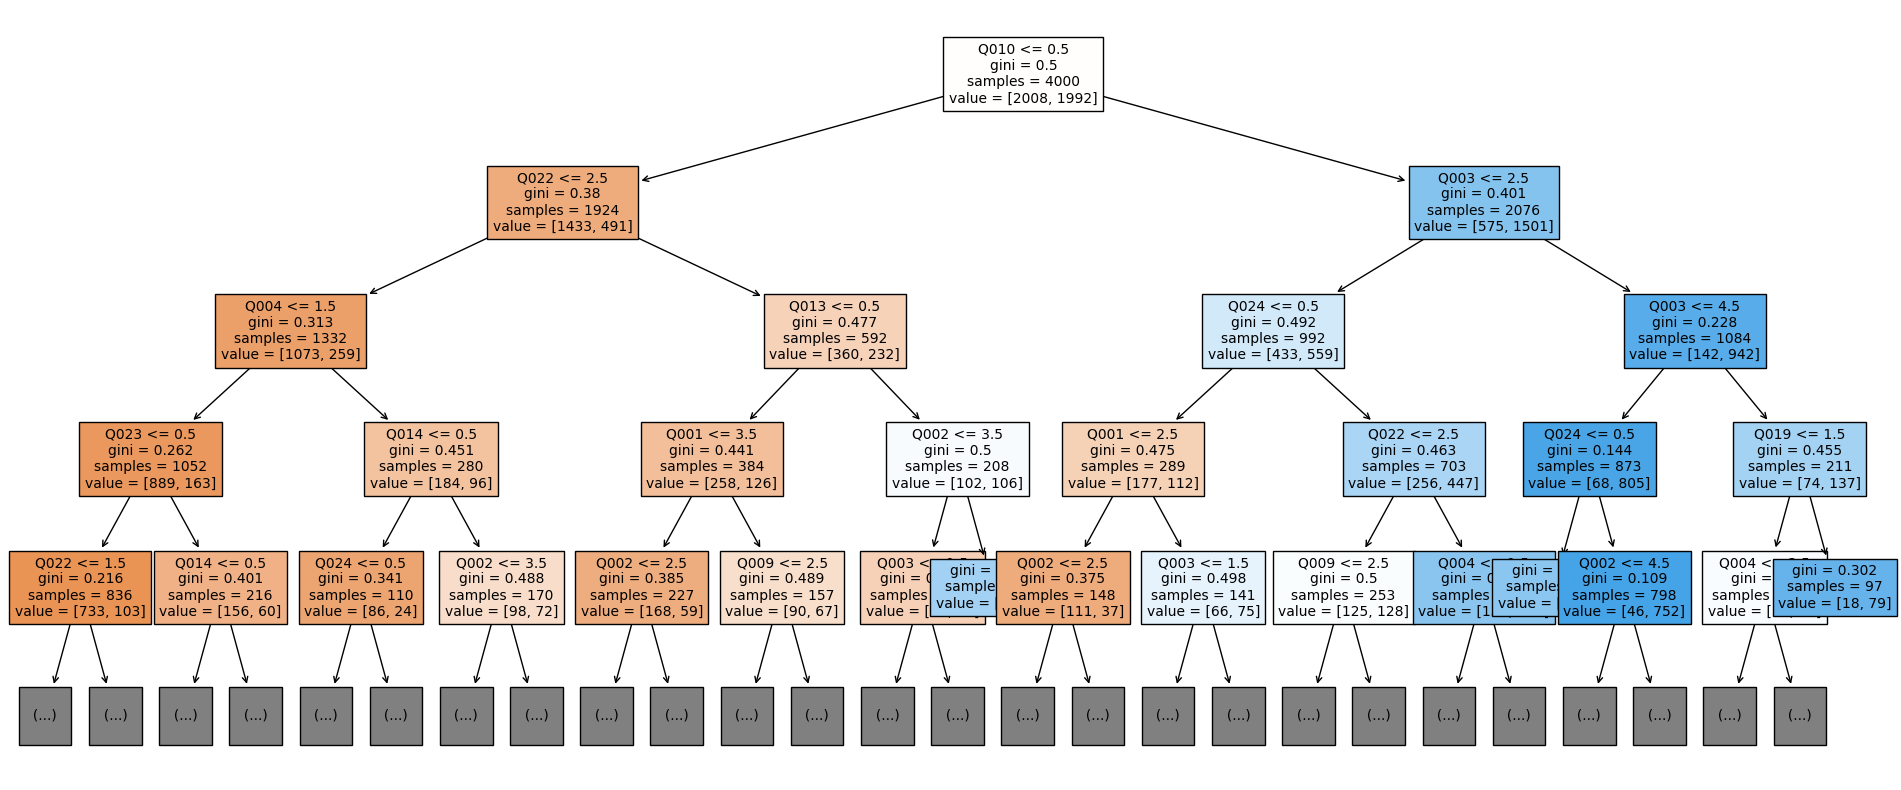

In [132]:
plt.figure(figsize=(24, 10))
plot_tree(tree, filled=True, fontsize=10, feature_names=X_train.columns, max_depth=4)
plt.show()

In [133]:
# Para tornar mais inteligível, alterei o nome das colunas por uma palavra-chave associada à cada questão
mapa_questao_palavra = {
    "Q001": "estudo_pai",
    "Q002": "estudo_mae",
    "Q003": "ocupacao_pai",
    "Q004": "ocupacao_mae",
    "Q005": "num_moradores",
    "Q007": "empregado_domestico",
    "Q008": "banheiro",
    "Q009": "quartos",
    "Q010": "carro",
    "Q011": "motocicleta",
    "Q012": "geladeira",
    "Q013": "freezer",
    "Q014": "lava_roupa",
    "Q015": "seca_roupa",
    "Q016": "micro_ondas",
    "Q017": "lava_louca",
    "Q018": "aspirador",
    "Q019": "tv_colorida",
    "Q020": "DVD",
    "Q021": "tv_assinatura",
    "Q022": "celular",
    "Q023": "tel_fixo",
    "Q024": "computador",
    "Q025": "internet",
}

In [134]:
X.columns

Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q007', 'Q008', 'Q009', 'Q010',
       'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019',
       'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [135]:
X.columns = [mapa_questao_palavra[questao] for questao in X.columns]
X.columns

Index(['estudo_pai', 'estudo_mae', 'ocupacao_pai', 'ocupacao_mae',
       'num_moradores', 'empregado_domestico', 'banheiro', 'quartos', 'carro',
       'motocicleta', 'geladeira', 'freezer', 'lava_roupa', 'seca_roupa',
       'micro_ondas', 'lava_louca', 'aspirador', 'tv_colorida', 'DVD',
       'tv_assinatura', 'celular', 'tel_fixo', 'computador', 'internet'],
      dtype='object')

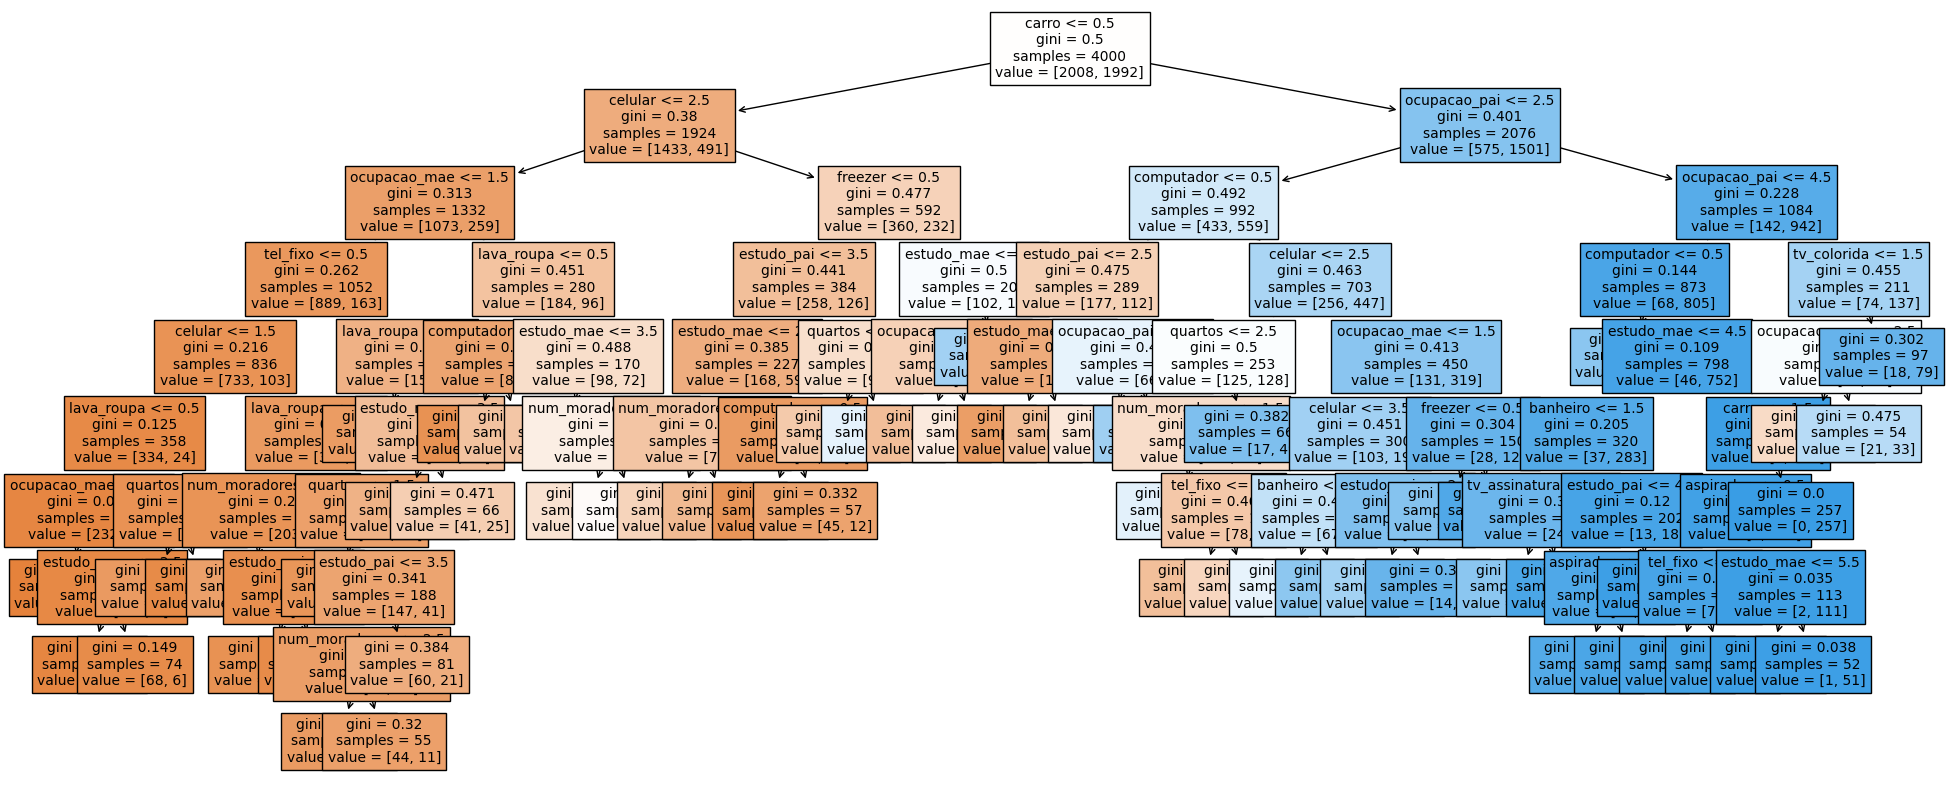

In [136]:
plt.figure(figsize=(24, 10))
plot_tree(tree, filled=True, fontsize=10, feature_names=X.columns)
plt.show()

In [168]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [169]:
import sys
import os

# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

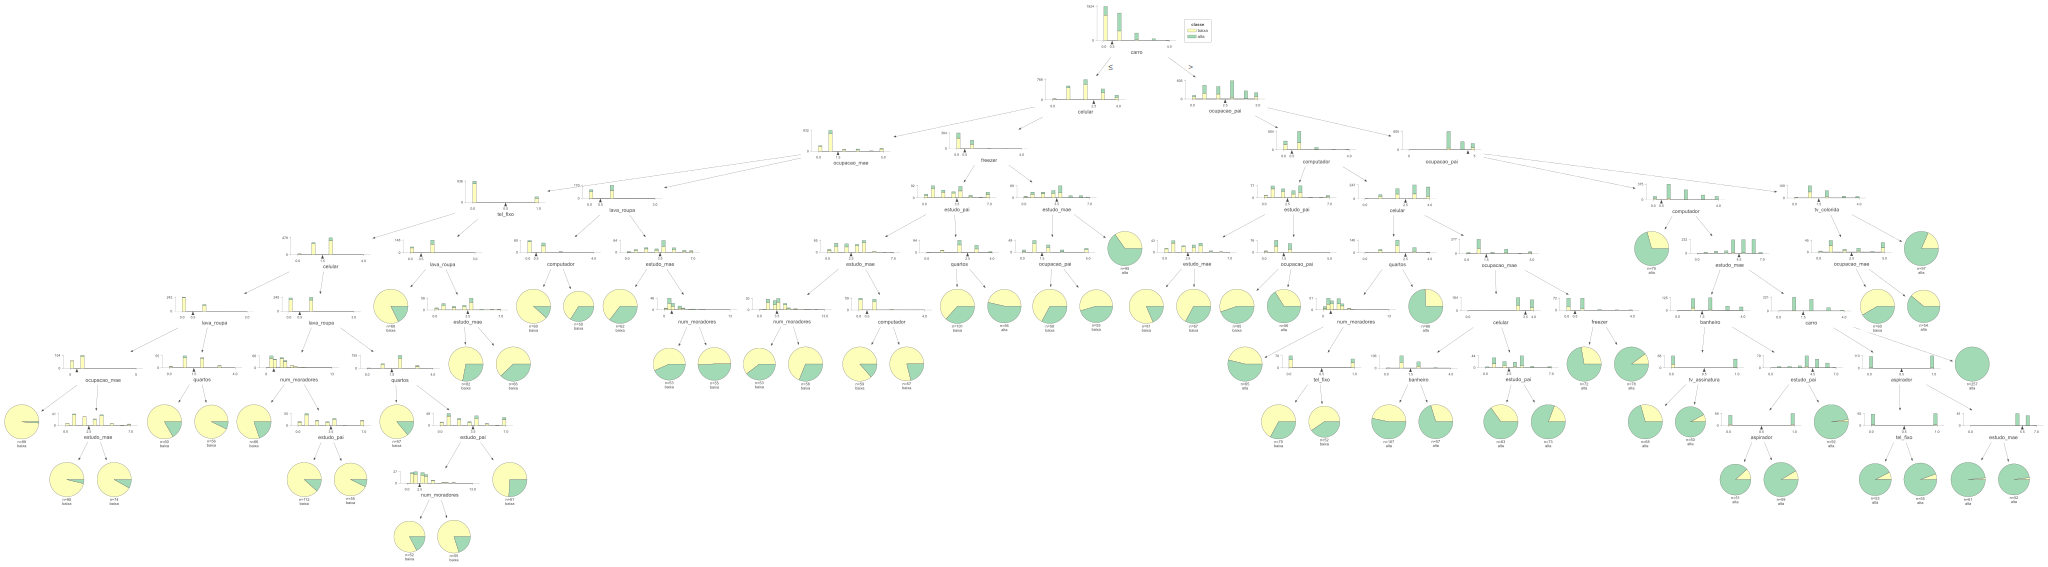

In [139]:
# Suppress warnings
import logging

logging.getLogger("matplotlib.font_manager").disabled = True

import dtreeviz

viz = dtreeviz.model(
    tree,
    enc.transform(X_train),
    y_train,
    target_name="classe",
    feature_names=list(X.columns),
    class_names=["baixa", "alta"],
)

viz.view(scale=0.8)

In [170]:
# Avaliação sistemática da importância das diversas variáveis independências
# !!permutation importance !!
X

,estudo_pai,estudo_mae,ocupacao_pai,ocupacao_mae,num_moradores,empregado_domestico,banheiro,quartos,carro,motocicleta,...,micro_ondas,lava_louca,aspirador,tv_colorida,DVD,tv_assinatura,celular,tel_fixo,computador,internet
0,D,E,C,D,2,B,C,D,B,A,...,B,A,A,C,A,A,C,A,B,B
1,G,G,D,D,2,A,B,C,A,A,...,B,A,A,B,A,A,C,B,A,B
2,F,E,D,B,4,A,B,C,A,A,...,A,A,A,B,A,A,D,B,A,B
3,E,E,A,C,3,A,B,C,A,A,...,A,A,A,B,B,B,C,A,A,B
4,E,C,F,F,4,C,C,C,B,A,...,B,A,A,C,B,A,C,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,E,G,F,B,4,A,B,D,A,B,...,B,A,A,B,A,A,D,A,B,B
4996,E,E,D,B,3,A,C,C,B,A,...,B,A,B,C,B,B,D,B,C,B
4997,E,E,D,B,4,A,D,D,B,A,...,B,A,A,B,A,A,D,B,B,B
4998,C,A,C,B,3,B,B,D,A,A,...,B,A,B,B,A,A,D,B,B,B


In [141]:
# viz.save_svg()

SVG com gráfico dtreeviz de árvore de decisão para estimar renda familiar a partir de dados do questionário socioeconômico do Enem 2019 DF

![SVG com gráfico dtreeviz de árvore de decisão para estimar renda familiar a partir de dados do questionário socioeconômico do Enem 2019 DF](https://gist.githubusercontent.com/EMFS/f93c15523955f8a6009d055cdd8991a8/raw/3cb1f374143d56f9a8a278b598362efedab71ae8/arvore_decisao_renda_familiar_enem_2019.svg)


#### Entendimento de toda árvore criando pelo modelo acima


**Visualização avançada de árvore de decisão:**

- a cada nó seleciona-se (automaticamente) a variável do questionário sócio economico que melhor permite separar as classes `"alta renda" e "baixa renda"` que estão misturadas na população (50/50%, para o valor R$ 1.500,00 mensais de renda familiar, de acordo com dados do Enem 2019 para o DF).

- Cada nó divide-se em dois ramos: o da direita é aquele em que o valor é maior do que o do ponto de corte do nó e o da esquerda em que esse valor é menor. Além disso, em cada nó mostra-se o histograma de distribuição de valores daquela variável, a proporção relativa de rendas alta e baixa e onde fica o ponto de corte. Assim você interpreta a árvore de decisão partindo do topo:

1. A primeira variável selecionada para melhor separar essas classes alta e baixa é a quantidade de carros, com ponto de corte em 0,5: a direita tem o subgrupo com 1 ou mais carros; à esquerda o sub-grupo com 0 carros. Assim, sucessivamente, vai-se subdividindo a amostra para isolar subgrupos mais homogêneos, separando alta e baixa renda. A sequência da variáveis selecionadas e seus pontos de corte é reveladora daquilo que mais distingue esses grupos e como identificá-los automaticamente a partir de algumas respostas de questionários.

2. No galho à direita, preponderantemente mais rico, o próximo critério é a classificação de ocupação profissional do pai. Já no galho da esquerda, dos mais pobres, o critério de subclassificação passa a ser o número de telefones celulares na família...

Na base da árvore temos as folhas finais da árvore, em que suspendemos o processo de subdivisão e que permite visualizar a proporção das classes alta e baixa. O critério de sucesso da árvore de decisão é quando as folhas finais seriam maximamente "puras" com uma alta proporção de uma única classe.

Nesse caso, limitamos a profundidade da árvore antes das folhas serem tão puras, para facilitar a interpretação do resultado.

O detalhe do significado de cada variável e seus patamares de valores encontra-se detalhado no dicionário de dados do Enem 2019: [https://drive.google.com/file/d/1hUB_2ySBsOfvIQxHxL4cyE7WY_739BhB/view](https://drive.google.com/file/d/1hUB_2ySBsOfvIQxHxL4cyE7WY_739BhB/view)


### Modelo _RandomForestClassifier_ (Floresta Aleatória)


In [142]:
# Testando outros modelos: Floresta Aleatória
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(enc.transform(X_train), y_train)
print(rf.score(enc.transform(X_test), y_test))
metrics.f1_score(y_test, rf.predict(enc.transform(X_test)), average="weighted")

0.773


0.7724330469898759

### Comparando resultados de diversos modelos

Como de costume o Random Forrest funcionou bem, mas o modelo de regressão logística ficou um pouco melhor, com 31% de acurácia e 25,7% de F1-score

Como melhorar esse modelo?

Teste de one-hot encoding para as variáveis categóricas?
Inserção do pré-treinamento em um pipeline, avaliação com validação cruzada?
Busca por hiper parâmetros otimizados?

Outras abordagens:
O grão de distinção das classes de renda é relativamente baixo, talvez agregando um pouco mais essas classes de renda torne o resultado melhor?
Talvez distinguir apenas 3 níveis: baixo (-25%), médio (50%) e alto (+25%)

Finalmente, como combinar diversos modelos para produzir um resultado melhor do que qualquer um deles? **`Ensemble...`**

## Ensemble

Conjunto de modelos cujo resultado médio supera o de todos os integrantes do modelo!


Reagrupando os resultados colhidos dos modelos anteriores:

| modelo                 | acurácia | F1 score           | variável |
| ---------------------- | -------- | ------------------ | -------- |
| LogisticRegression     | 0.767    | 0.7665589314855262 | log_reg  |
| SVM                    | 0.765    | 0.763278444854521  | svm_clf  |
| DecisionTreeClassifier | 0.765    | 0.6620229840919364 | tree     |
| RandomForestClassifier | 0.771    | 0.7704280518091701 | rf       |


In [143]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

gnb = GaussianNB()

eclf = VotingClassifier(
    estimators=[
        ("log_reg", log_reg),
        ("SVM", svm_clf),
        ("tree", tree),
        ("RF", rf),
        ("gnb", gnb),
    ],
    voting="hard",
)

for clf, label in zip(
    [log_reg, svm_clf, tree, rf, gnb, eclf],
    [
        "Logistic Regression",
        "SVM",
        "Decision Tree",
        "Random Forest",
        "Naive Bayes",
        "Ensemble",
    ],
):
    scores = cross_val_score(
        clf, enc.transform(X_train), y_train, scoring="accuracy", cv=5
    )
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")

Logistic Regression : 0.765 (+/- 0.011)
SVM : 0.764 (+/- 0.006)
Decision Tree : 0.738 (+/- 0.015)
Random Forest : 0.764 (+/- 0.010)
Naive Bayes : 0.739 (+/- 0.011)
Ensemble : 0.766 (+/- 0.007)


# Conclusão


### Aplicamos diversas técnicas sobre o dataset ENEM:

- Pré-processamento:
  - encoding de dados categóricos
  - normalização de dados numéricos
  - imputação de dados faltantes
  - seleção de features
- Particionamento treino/validação
- Modelos simples: avaliação, casos de erro
- Pipeline, cross validation...
- diversos modelos: Logistic Regression, SVM, Decision Tree, Random Forest, Naive Bayes
- gráficos e interpretação de árvores de decisão
- Ensemble de modelos


## Interpretação de Random Forest


In [144]:
# Principais parâmetros para o modelo RF
m = RandomForestClassifier(
    n_estimators=40,
    min_samples_leaf=5,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
    oob_score=True,
)
m.fit(enc.transform(X_train), y_train)

RandomForestClassifier(max_features=0.5, min_samples_leaf=5, n_estimators=40,
                       n_jobs=-1, oob_score=True, random_state=42)

In [145]:
m.score(enc.transform(X_test), y_test)

0.777

In [146]:
# Feature Importance
# Contribuição na redução do nível de impureza das classes ao utilizar essa feature
m.feature_importances_

array([0.06560636, 0.05470849, 0.07935732, 0.06570432, 0.0461667 ,
       0.00101551, 0.06037401, 0.02385225, 0.27545202, 0.0035495 ,
       0.0003335 , 0.02171328, 0.01890912, 0.00531271, 0.01487848,
       0.        , 0.02271452, 0.03841433, 0.01237369, 0.0394143 ,
       0.06779921, 0.01929819, 0.0520451 , 0.01100706])

In [147]:
m.feature_importances_.sum()

1.0

In [148]:
# zip = juntar dadps
list(zip(X.columns, m.feature_importances_))

[('estudo_pai', 0.06560636307775222),
 ('estudo_mae', 0.05470848958498672),
 ('ocupacao_pai', 0.07935732471444079),
 ('ocupacao_mae', 0.06570432213888609),
 ('num_moradores', 0.04616669839710223),
 ('empregado_domestico', 0.001015509352209349),
 ('banheiro', 0.06037401475720188),
 ('quartos', 0.02385225168308334),
 ('carro', 0.27545201540284264),
 ('motocicleta', 0.003549495713613735),
 ('geladeira', 0.0003335047626562154),
 ('freezer', 0.02171327843478009),
 ('lava_roupa', 0.018909119910477452),
 ('seca_roupa', 0.005312713748604979),
 ('micro_ondas', 0.014878479368753979),
 ('lava_louca', 0.0),
 ('aspirador', 0.022714523970276856),
 ('tv_colorida', 0.03841433306324407),
 ('DVD', 0.012373694504116357),
 ('tv_assinatura', 0.03941430244533117),
 ('celular', 0.06779921034421303),
 ('tel_fixo', 0.01929819041960799),
 ('computador', 0.05204510338807996),
 ('internet', 0.011007060817738912)]

In [149]:
imp = pd.DataFrame(data=m.feature_importances_, index=X.columns, columns=["importance"])
imp.sort_values("importance", ascending=False)

,importance
carro,0.275452
ocupacao_pai,0.079357
celular,0.067799
ocupacao_mae,0.065704
estudo_pai,0.065606
banheiro,0.060374
estudo_mae,0.054708
computador,0.052045
num_moradores,0.046167
tv_assinatura,0.039414


<Axes: >

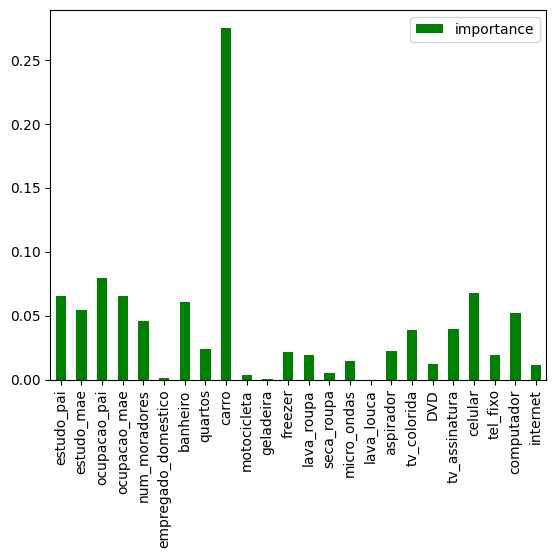

In [172]:
# distribuição do número de alunos por nível de renda
# df.Q006.value_counts().sort_index().plot.bar(color="blue")
imp.plot.bar(color="green")

In [150]:
# Cada árvore da floresta pode ser avaliada individualmente, inclusive na importância das features:
m.estimators_

[DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=1608637542),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=1273642419),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=1935803228),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=787846414),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=996406378),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=1201263687),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=423734972),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=415968276),
 DecisionTreeClassifier(max_features=0.5, min_samples_leaf=5,
                        random_state=670094950

In [151]:
std = np.std([tree.feature_importances_ for tree in m.estimators_], axis=0)
std

array([0.02271266, 0.01315751, 0.03061359, 0.05310954, 0.00917356,
       0.00116232, 0.08756533, 0.00764432, 0.1108805 , 0.00255981,
       0.00058655, 0.00783465, 0.00797882, 0.00410325, 0.00540968,
       0.        , 0.03283604, 0.06785479, 0.00557329, 0.03446302,
       0.04558894, 0.00490949, 0.02265701, 0.00680854])

In [152]:
indices = np.argsort(m.feature_importances_)[::-1]
indices

array([ 8,  2, 20,  3,  0,  6,  1, 22,  4, 19, 17,  7, 16, 11, 21, 12, 14,
       18, 23, 13,  9,  5, 10, 15], dtype=int64)

<Figure size 640x480 with 0 Axes>

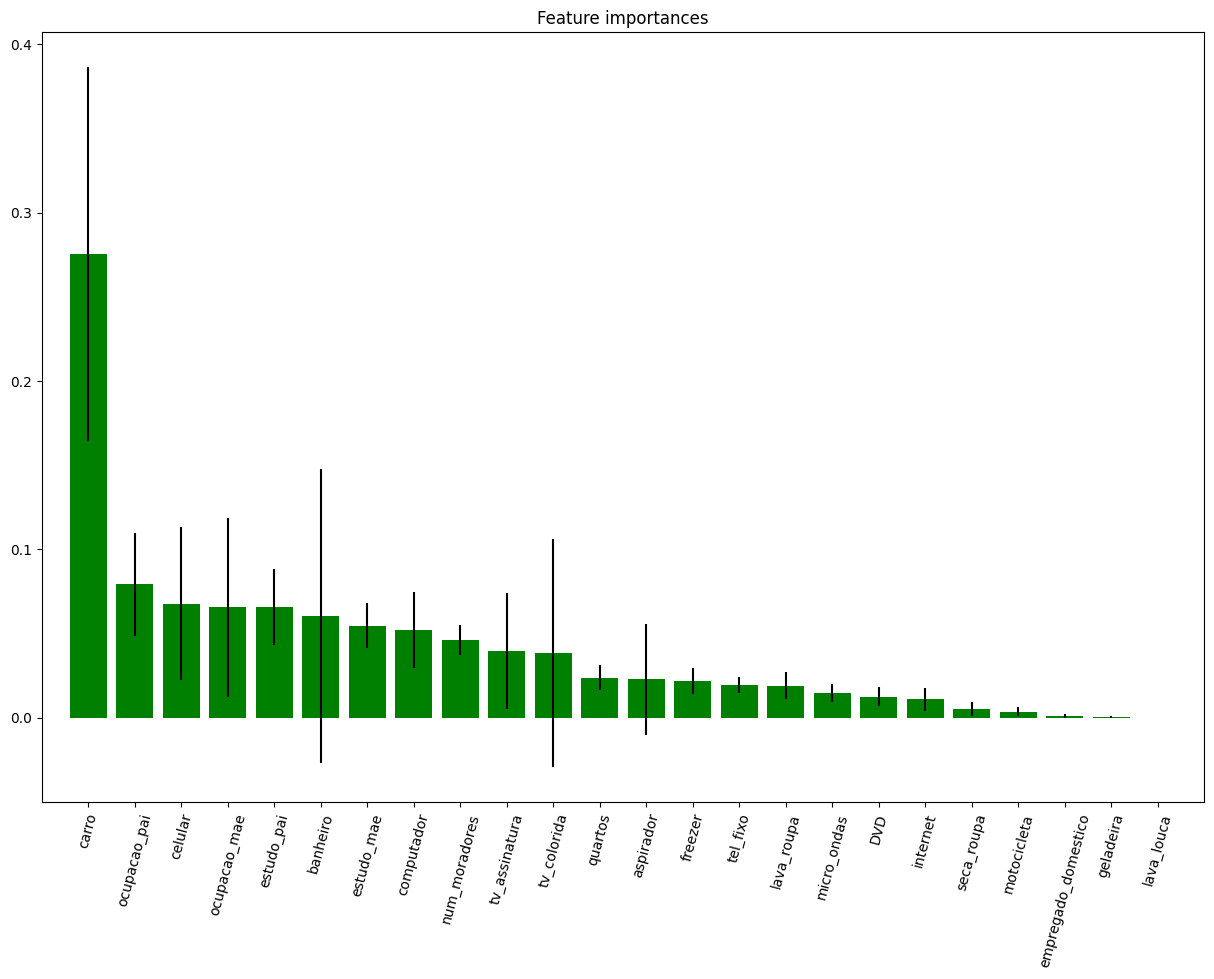

In [153]:
plt.figure()
plt.figure(figsize=(15, 10))
plt.title("Feature importances")
plt.bar(
    range(X.shape[1]),
    m.feature_importances_[indices],
    color="g",
    yerr=std[indices],
    align="center",
)
plt.xticks(
    range(X.shape[1]), 
    X.columns[indices], 
    rotation=75)
plt.xlim([-1, X.shape[1]])
plt.show()

# Próximos passos

## 1. Treinar um novo modelo utilizando apenas as colunas de maior importância e comparar o desempenho

Isso remove fonte de colinearidade. Analisar feature importance do modelo reduzido

## 2. Método sistemático de avaliar a importância de uma variável independente (feature) em qualquer modelo

(sem precisar treinar um novo modelo)

Treine o modelo com seus dados completos e teste seu desempenho. Depois use o modelo treinado para realizar previsões sobre seu conjunto de teste, só que dessa vez permute aleatoriamente os dados de uma das variáveis (features).

A queda de desempenho do seu modelo indica a importância dessa variável!

Ref: sklearn.inspection.permutation_importance: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

Ref2: https://www.kaggle.com/dansbecker/permutation-importance
